In [1]:
# Torch imports
from torch.utils.data import DataLoader

# Custom imports
import torch
import heuristics
from dataset_utils import PathPlanningDataset
from classic_astar import Astar
from training_module import NeuralAstarTrainingModule
from neural_astar import NeuralAstar
import lightning as pl
from differentiable_astar import DifferentiableAstar
import encoders

In [2]:
# Dataset Generation

initial_dataset = PathPlanningDataset(
    "/workspaces/datasets/raw/street",
    16,
    5,
    heuristics.euclidean,
    randomize_points=False,
    max_astar_iterations=10000,
)

training_dataloader = DataLoader(
    initial_dataset, batch_size=5, shuffle=True, drop_last=True, num_workers=7
)  # TODO fix for batch_size = 1

Path not found, skipping:  Path not found
Path not found, skipping:  Path not found
Path not found, skipping:  Path not found


In [3]:
# Create Astar instances
classic_astar = Astar(
    heuristic=heuristics.euclidean, costmap_weight=1, heuristic_weight=1
)
differentiable_astar = DifferentiableAstar(max_iterations=5000, costmap_weight=2)

In [4]:
cnn = encoders.CNN(2, 2)
astar_encoder = encoders.AstarEncoder()
astar_encoder.add_encoder(cnn)

In [5]:
neural_astar = NeuralAstar(
    classic_astar=classic_astar,
    differentiable_astar=differentiable_astar,
    encoder=astar_encoder,
    use_start_goal_data=True,
)

In [6]:
astar_training_module = NeuralAstarTrainingModule(neural_astar=neural_astar)

In [7]:
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=1,
    default_root_dir="../logs/",
    max_epochs=10,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(astar_training_module, training_dataloader)


  | Name          | Type        | Params
----------------------------------------------
0 | neural_astar_ | NeuralAstar | 19.9 K
----------------------------------------------
19.9 K    Trainable params
9         Non-trainable params
19.9 K    Total params
0.080     Total estimated model params size (MB)


Epoch 0:   2%|▏         | 2/89 [00:00<00:09,  9.41it/s, v_num=2]

/opt/conda/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 9: 100%|██████████| 89/89 [00:03<00:00, 28.19it/s, v_num=2, train_loss=0.0475]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 89/89 [00:03<00:00, 28.13it/s, v_num=2, train_loss=0.0475]


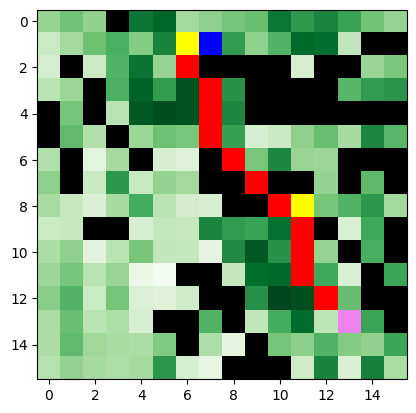

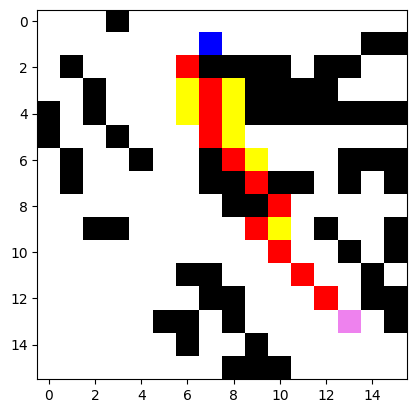

In [9]:
from display import Displayer
import matplotlib.pyplot as plt

map_batch, start_batch, goal_batch, path_batch = next(iter(training_dataloader))
map_batch = map_batch.unsqueeze(1)
start_batch = start_batch.unsqueeze(1)
goal_batch = goal_batch.unsqueeze(1)

cosmtap_batch = neural_astar._get_cost_batch(map_batch, start_batch + goal_batch)
cosmtap_batch = cosmtap_batch.detach()
out_path, out_searched = neural_astar(map_batch, start_batch, goal_batch)

out_path_classic, out_searched_classic = classic_astar.forward(
    map_batch, start_batch, goal_batch, None
)


d = Displayer()
d.add_matrix(map_batch[0, 0])
d.add_start(start_batch[0, 0])
d.add_goal(goal_batch[0, 0])
d.add_searched_nodes(out_searched[0, 0])
d.add_solution(out_path[0, 0])
d.add_cost_matrix(cosmtap_batch[0, 0])
d.prepare_plot()
d.draw()

d = Displayer()
d.add_matrix(map_batch[0, 0])
d.add_start(start_batch[0, 0])
d.add_goal(goal_batch[0, 0])
d.add_searched_nodes(out_searched_classic[0, 0])
d.add_solution(out_path_classic[0, 0])
# d.add_cost_matrix(cosmtap_batch[0, 0])
d.prepare_plot()
d.draw()